In [2]:
#======================================================================================================
# *WandB 툴을 이용하여, loss를 시각화함(http://wandb.ai 에 회원가입 해야 함)
# => !pip install wandb -qqq 
#
#
#======================================================================================================
#!pip install wandb -qqq
import wandb
wandb.login()  # 로그인 => wandb.ai 사이트에 로그인 후, API Key 입력해야 함

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /MOCOMSYS/.netrc


True

In [5]:
#======================================================================================================
# bert BertForSequenceClassification finetuning 예제
# 참고 사이트 : https://zzaebok.github.io/deep_learning/nlp/Bert-for-classification/
#
#======================================================================================================

import numpy as np
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, BertModel, AdamW, get_linear_schedule_with_warmup
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch.nn.functional as F

import sys
sys.path.append('..')
from myutils import seed_everything, GPU_info, mlogging
from tqdm.notebook import tqdm
import os

logger = mlogging(loggername="bertfttrain", logfilename="../../log/bertftmultitrain")
device = GPU_info()
seed_everything(111)



logfilepath:../../log/bertftmultitrain_2022-04-14.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30


In [6]:
##############################################################################################
# 변수들 설정
# - model_path : from_pretrained() 로 호출하는 경우에는 모델파일이 있는 폴더 경로나 
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')
#          torch.load(model)로 로딩하는 경우에는 모델 파일 풀 경로
#
# - vocab_path : from_pretrained() 호출하는 경우에는 모델파일이 있는 폴더 경로나
#          huggingface에 등록된 모델명(예:'bert-base-multilingual-cased')   
#          BertTokenizer() 로 호출하는 경우에는 vocab.txt 파일 풀 경로,
#
# - OUTPATH : 출력 모델, vocab 저장할 폴더 경로
#############################################################################################

#model_path = 'model/kobertmodel/'
#vocab_path = 'model/kobertmodel/vocab/vocab.txt'
#OUTPATH = 'model/classification/kobert-ft-es-cfmodel/'

model_path = '../../model/bert/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327/'
vocab_path = '../../model/bert/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327/'
OUTPATH = '../../model/classification/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327-nscm-0414/'

# tokeniaer 및 model 설정
#tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# strip_accents=False : True로 하면, 가자 => ㄱ ㅏ ㅈ ㅏ 식으로 토큰화 되어 버림(*따라서 한국어에서는 반드시 False)
# do_lower_case=False : # 소문자 입력 사용 안함(한국어에서는 반드시 False)
#tokenizer = BertTokenizer(vocab_file=vocab_path, strip_accents=False, do_lower_case=False) 
tokenizer = BertTokenizer.from_pretrained(vocab_path, do_lower_case=False)

# 레벨을 1개만 선택하는 경우
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)
#model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=6)

# 레벨을 멀티로 선택해야 하는 경우
#model = BertForSequenceClassification.from_pretrained(model_path, problem_type="multi_label_classification",num_labels=6)
                   
#기존 모델 파일을 로딩하는 경우    
#model = torch.load(model_path) 

model.to(device)

Some weights of the model checkpoint at ../../model/bert/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327/ were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from t

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(167550, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [7]:
model.num_parameters()

214721282

In [8]:
# wandb 관련 hyper parameter들 설정
wandb.init(
        project='bert-ft-multiclassification',
        config={
            "epochs": 3,
            "batch_size": 32,
            "lr": 2e-5,
        })

config = wandb.config

wandb: Currently logged in as: kobongsoo (use `wandb login --relogin` to force relogin)


In [11]:
# 학습 data loader 생성
from os import sys
sys.path.append('..')
from myutils import ClassificationCSVCorpus, ClassificationDataset, data_collator
from torch.utils.data import DataLoader, RandomSampler

#############################################################################
# 변수 설정
#############################################################################
max_seq_len = 128   # 글자 최대 토큰 길이 해당 토큰 길이 이상은 잘린다.
#batch_size = 32        # 배치 사이즈(64면 GUP Memory 오류 나므로, 32 이하로 설정할것=>max_seq_length 를 줄이면, 64도 가능함)

# 훈련할 csv 파일
#file_fpath = 'korpora/감성대화말뭉치/감성대화말뭉치(최종데이터)_renew_labelenc_Training.csv'
file_fpath = '../../korpora/nsmc/ratings_train.txt'
column_num = 3           # .csv 파일에 컬럼수(예: text, label만 있으면 =2)
csvfile = 0              # 0:tsv 파일, 1: csv 파일
label_list = ["0", "1"]  # .csv 파일에 레벨 목록( list로 입력해야 함)
#label_list = ["0", "1", "2", "3", "4", "5"]  # .csv 파일에 레벨 목록( list로 입력해야 함)
cache = False   # 캐쉬파일 생성할거면 True로 (True이면 loding할때 캐쉬파일있어도 이용안함)
#############################################################################

# corpus 파일 설정
corpus = ClassificationCSVCorpus(column_num=column_num, iscsvfile=csvfile, label_list=label_list)

# 학습 dataset 생성
dataset = ClassificationDataset(file_fpath=file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)


# 학습 dataloader 생성
train_loader = DataLoader(dataset, 
                          batch_size=config.batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

# 평가 dataset 생성
#file_fpath = 'korpora/감성대화말뭉치/감성대화말뭉치(최종데이터)_renew_labelenc_Validation.csv'
file_fpath = '../../korpora/nsmc/ratings_test.txt'
dataset = ClassificationDataset(file_fpath=file_fpath, max_seq_length=max_seq_len, tokenizer=tokenizer, corpus=corpus, overwrite_cache=cache)


# 평가 dataloader 생성
eval_loader = DataLoader(dataset, 
                          batch_size=config.batch_size, 
                          #shuffle=True, # dataset을 섞음
                          sampler=RandomSampler(dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          collate_fn=data_collator, # dataset을 tensor로 변환(예시 {'input_ids':tensor[0,1,2,3,1,], 'token_type_id:tensor[0,0,0,0,0], 'attention_mask:tensor[1,1,1,1,1], 'labels':tensor[5]}
                          num_workers=4)

2022-04-14 09:39:03,424 - bwpdataset - INFO - Loading features from cached file ../../korpora/nsmc/cached_BertTokenizer_128_ratings_train.txt [took 8.132 s]
2022-04-14 09:39:05,308 - bwpdataset - INFO - Loading features from cached file ../../korpora/nsmc/cached_BertTokenizer_128_ratings_test.txt [took 1.450 s]


In [12]:
# tokenier 테스트
print(len(tokenizer))
print(tokenizer.encode("눈에 보이는 반전이었지만 영화의 흡인력은 사라지지 않았다"))
print(tokenizer.convert_ids_to_tokens(1000))
print(tokenizer.convert_tokens_to_ids('날씨'))

167550
[101, 9034, 10530, 124997, 11018, 125215, 10739, 69708, 42428, 10459, 10020, 129937, 10892, 132489, 12508, 49137, 102]
৭
123665


In [16]:
# 학습 시작
   
    ##################################################
    # 변수 설정
    ##################################################
    epochs = config.epochs            # epochs
    learning_rate = config.lr  # 학습률
    p_itr = 400           # 손실률 보여줄 step 수
    ##################################################

    # optimizer 적용
    optimizer = AdamW(model.parameters(), 
                     lr=learning_rate, 
                     eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

    # 총 훈련과정에서 반복할 스탭
    total_steps = len(train_loader)*epochs

    # 스캐줄러 생성
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                num_warmup_steps=0, 
                                                num_training_steps=total_steps)

    itr = 1
    total_loss = 0
    total_len = 0
    total_correct = 0
    list_training_loss = []
    list_acc_loss = []
    list_validation_acc_loss = []

    model.zero_grad()# 그래디언트 초기화
    for epoch in tqdm(range(epochs)):

        model.train() # 훈련모드로 변환
        for data in tqdm(train_loader):

            #optimizer.zero_grad()
            model.zero_grad()# 그래디언트 초기화

            # 입력 값 설정
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)       
            labels = data['labels'].to(device)
            #print('Labels:{}'.format(labels))

            # 모델 실행
            outputs = model(input_ids=input_ids, 
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            labels=labels)

            # 출력값 loss,logits를 outputs에서 얻어옴
            loss = outputs.loss
            logits = outputs.logits
            #print('Loss:{}, logits:{}'.format(loss, logits))

            # optimizer 과 scheduler 업데이트 시킴
            loss.backward()   # backward 구함
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)
            optimizer.step()  # 가중치 파라미터 업데이트(optimizer 이동)
            scheduler.step()  # 학습률 감소

            # 정확도와 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
            # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
            # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
            with torch.no_grad():
                # 정확도와 총 손실률 계산
                pred = torch.argmax(F.softmax(logits), dim=1)
                correct = pred.eq(labels)
                total_correct += correct.sum().item()
                total_len += len(labels)    
                total_loss += loss.item()

                # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
                if itr % p_itr == 0:

                    logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Accuracy: {:.3f}'.format(epoch+1, epochs, itr, total_loss/p_itr, total_correct/total_len))

                    # wandb 로그 기록
                    wandb.log({"Loss": total_loss/p_itr,
                              "Accuracy": total_correct/total_len
                              })

                    list_training_loss.append(total_loss/p_itr)
                    list_acc_loss.append(total_correct/total_len)

                    total_loss = 0
                    total_len = 0
                    total_correct = 0


            itr+=1

        ####################################################################
        # 1epochs 마다 실제 test(validattion)데이터로 평가 해봄
        # 평가 시작
        model.eval()

        total_test_correct = 0
        total_test_len = 0

        for data in tqdm(eval_loader):
            # 입력 값 설정
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)       
            labels = data['labels'].to(device)

            # 손실률 계산하는 부분은 no_grade 시켜서, 계산량을 줄임.
            # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
            # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
            with torch.no_grad():
                # 모델 실행
                outputs = model(input_ids=input_ids, 
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                labels=labels)

                # 출력값 loss,logits를 outputs에서 얻어옴
                #loss = outputs.loss
                logits = outputs.logits

                # 총 손실류 구함
                pred = torch.argmax(F.softmax(logits), dim=1)
                correct = pred.eq(labels)
                total_test_correct += correct.sum().item()
                total_test_len += len(labels)

        list_validation_acc_loss.append(total_test_correct/total_test_len)
        logger.info("[Epoch {}/{}] Validatation Accuracy:{}".format(epoch+1, epochs, total_test_correct / total_test_len))

        # wandb 로그 기록
        wandb.log({"Validatation Accurac": total_test_correct / total_test_len
                  })

        ####################################################################
   
        

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4688 [00:00<?, ?it/s]

/tmp/ipykernel_110173/830095837.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
2022-04-14 09:48:55,961 - bertfttrain - INFO - [Epoch 1/3] Iteration 400 -> Train Loss: 0.4004, Train Accuracy: 0.820
2022-04-14 09:48:55,961 - bertfttrain - INFO - [Epoch 1/3] Iteration 400 -> Train Loss: 0.4004, Train Accuracy: 0.820
2022-04-14 09:49:53,234 - bertfttrain - INFO - [Epoch 1/3] Iteration 800 -> Train Loss: 0.3688, Train Accuracy: 0.836
2022-04-14 09:49:53,234 - bertfttrain - INFO - [Epoch 1/3] Iteration 800 -> Train Loss: 0.3688, Train Accuracy: 0.836
2022-04-14 09:50:52,316 - bertfttrain - INFO - [Epoch 1/3] Iteration 1200 -> Train Loss: 0.3576, Train Accuracy: 0.841
2022-04-14 09:50:52,316 - bertfttrain - INFO - [Epoch 1/3] Iteration 1200 -> Train Loss: 0.3576, Train Accuracy: 0.841
2022-04-14 09:51:49,786 - bertfttrain - INFO - [Epoch 1/3] Iteration 1600 -> Train

  0%|          | 0/1563 [00:00<?, ?it/s]

/tmp/ipykernel_110173/830095837.py:126: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
2022-04-14 10:00:14,774 - bertfttrain - INFO - [Epoch 1/3] Validatation Accuracy:0.86842
2022-04-14 10:00:14,774 - bertfttrain - INFO - [Epoch 1/3] Validatation Accuracy:0.86842


  0%|          | 0/4688 [00:00<?, ?it/s]

2022-04-14 10:00:31,120 - bertfttrain - INFO - [Epoch 2/3] Iteration 4800 -> Train Loss: 0.2954, Train Accuracy: 0.874
2022-04-14 10:00:31,120 - bertfttrain - INFO - [Epoch 2/3] Iteration 4800 -> Train Loss: 0.2954, Train Accuracy: 0.874
wandb: Network error (ReadTimeout), entering retry loop.
2022-04-14 10:01:29,899 - bertfttrain - INFO - [Epoch 2/3] Iteration 5200 -> Train Loss: 0.2530, Train Accuracy: 0.898
2022-04-14 10:01:29,899 - bertfttrain - INFO - [Epoch 2/3] Iteration 5200 -> Train Loss: 0.2530, Train Accuracy: 0.898
2022-04-14 10:02:27,041 - bertfttrain - INFO - [Epoch 2/3] Iteration 5600 -> Train Loss: 0.2512, Train Accuracy: 0.895
2022-04-14 10:02:27,041 - bertfttrain - INFO - [Epoch 2/3] Iteration 5600 -> Train Loss: 0.2512, Train Accuracy: 0.895
2022-04-14 10:03:26,956 - bertfttrain - INFO - [Epoch 2/3] Iteration 6000 -> Train Loss: 0.2488, Train Accuracy: 0.902
2022-04-14 10:03:26,956 - bertfttrain - INFO - [Epoch 2/3] Iteration 6000 -> Train Loss: 0.2488, Train Accurac

  0%|          | 0/1563 [00:00<?, ?it/s]

2022-04-14 10:12:45,035 - bertfttrain - INFO - [Epoch 2/3] Validatation Accuracy:0.8761
2022-04-14 10:12:45,035 - bertfttrain - INFO - [Epoch 2/3] Validatation Accuracy:0.8761


  0%|          | 0/4688 [00:00<?, ?it/s]

2022-04-14 10:13:18,815 - bertfttrain - INFO - [Epoch 3/3] Iteration 9600 -> Train Loss: 0.2049, Train Accuracy: 0.917
2022-04-14 10:13:18,815 - bertfttrain - INFO - [Epoch 3/3] Iteration 9600 -> Train Loss: 0.2049, Train Accuracy: 0.917
2022-04-14 10:14:16,470 - bertfttrain - INFO - [Epoch 3/3] Iteration 10000 -> Train Loss: 0.1816, Train Accuracy: 0.931
2022-04-14 10:14:16,470 - bertfttrain - INFO - [Epoch 3/3] Iteration 10000 -> Train Loss: 0.1816, Train Accuracy: 0.931
2022-04-14 10:15:17,660 - bertfttrain - INFO - [Epoch 3/3] Iteration 10400 -> Train Loss: 0.1716, Train Accuracy: 0.933
2022-04-14 10:15:17,660 - bertfttrain - INFO - [Epoch 3/3] Iteration 10400 -> Train Loss: 0.1716, Train Accuracy: 0.933
2022-04-14 10:16:18,831 - bertfttrain - INFO - [Epoch 3/3] Iteration 10800 -> Train Loss: 0.1810, Train Accuracy: 0.930
2022-04-14 10:16:18,831 - bertfttrain - INFO - [Epoch 3/3] Iteration 10800 -> Train Loss: 0.1810, Train Accuracy: 0.930
2022-04-14 10:17:16,421 - bertfttrain - IN

  0%|          | 0/1563 [00:00<?, ?it/s]

2022-04-14 10:25:10,843 - bertfttrain - INFO - [Epoch 3/3] Validatation Accuracy:0.87786
2022-04-14 10:25:10,843 - bertfttrain - INFO - [Epoch 3/3] Validatation Accuracy:0.87786


In [18]:
# wnandb 종료
wandb.finish()

Accuracy,▁▂▂▂▃▃▃▃▃▄▄▄▆▆▆▆▆▆▆▆▆▆▆▇███████████
Loss,█▇▇▇▆▆▆▆▆▅▅▅▄▄▃▃▃▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁
Validatation Accurac,▁▇█
Accuracy,0.93617
Loss,0.17405
Validatation Accurac,0.87786


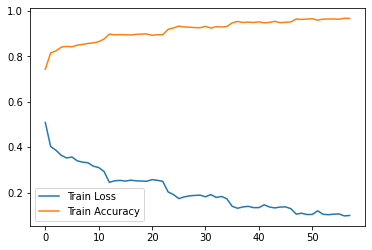

In [7]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_acc_loss, label='Train Accuracy')
plt.legend()
plt.show()

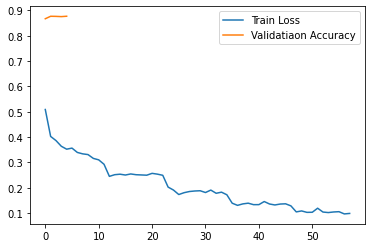

In [8]:
# train loss와 Validatiaon acc 출력
plt.plot(list_training_loss, label='Train Loss')
plt.plot(list_validation_acc_loss, label='Validatiaon Accuracy')
plt.legend()
plt.show()

In [9]:
### 전체모델 저장
os.makedirs(OUTPATH)
#torch.save(model, OUTPATH + 'pytorch_model.bin') 
model.save_pretrained(OUTPATH)  # save_pretrained 로 저장하면 config.json, pytorch_model.bin 2개의 파일이 생성됨

# tokeinizer 파일 저장(vocab)
VOCAB_PATH = OUTPATH + 'vocab'
os.makedirs(VOCAB_PATH)
tokenizer.save_pretrained(VOCAB_PATH)

('model/classification/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327-nscm-0329/vocab/tokenizer_config.json',
 'model/classification/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327-nscm-0329/vocab/special_tokens_map.json',
 'model/classification/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327-nscm-0329/vocab/vocab.txt',
 'model/classification/bmc-fpt-wiki_20190620_mecab_false_0311-nouns-0327-nscm-0329/vocab/added_tokens.json')

In [10]:
# 최종 평가 시작
model.eval()

total_loss = 0
total_len = 0
total_correct = 0

for data in tqdm(eval_loader):
   
    # 입력 값 설정
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    token_type_ids = data['token_type_ids'].to(device)       
    labels = data['labels'].to(device)
 
    # 모델 실행
    outputs = model(input_ids=input_ids, 
                   attention_mask=attention_mask,
                   token_type_ids=token_type_ids,
                   labels=labels)
    
     # 출력값 loss,logits를 outputs에서 얻어옴
    loss = outputs.loss
    logits = outputs.logits
    
    # 총 손실류 구함
    pred = torch.argmax(F.softmax(logits), dim=1)
    correct = pred.eq(labels)
    total_correct += correct.sum().item()
    total_len += len(labels)

print('Test-accuracy: ', total_correct / total_len)
logger.info(f"Test-accuracy: {total_correct / total_len}")
    


  0%|          | 0/1563 [00:00<?, ?it/s]

/tmp/ipykernel_83495/4265055506.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = torch.argmax(F.softmax(logits), dim=1)
2022-03-29 13:16:10,863 - bertfttrain - INFO - Test-accuracy: 0.87684


Test-accuracy:  0.87684


In [11]:
# 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능
'''
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, OUTPATH + 'all.tar')  
'''

"\ntorch.save({\n    'model': model.state_dict(),\n    'optimizer': optimizer.state_dict()\n}, OUTPATH + 'all.tar')  \n"